# Czech CPI Category Forecast – Analytical Record

This notebook documents the end-to-end process of forecasting five Czech CPI sub-indices to 2050. Each section explains the rationale behind key steps, alternative approaches tested, and the criteria used to select the final models.

**Sub-indices**:
1. Food & non-alcoholic beverages
2. Clothing & footwear
3. Housing, water, energy, fuels
4. Transport
5. Recreation & culture

Sections:
1. Data preparation
2. Exploratory diagnostics
3. Candidate forecasting methods
4. Comparative evaluation & selection
5. Final forecasts & uncertainty visualization

**How to use**: run each cell sequentially in a Jupyter environment. Charts render inline; results save to `figures/` and `forecasts_2024_2050.csv`.

In [95]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams["figure.dpi"] = 110

In [96]:
SOURCE_XLSX_PATH = Path("CEN10.xlsx")   # ČSÚ workbook
TIDY_CSV_PATH   = Path("cen10_tidy.csv")
FIG_DIR         = Path("figures")
FORECAST_CSV    = Path("forecasts_2024_2050.csv")

HORIZON_YEAR    = 2050
# Structural break for piece-wise trend. 
# Chosen to reflect potential major economic shifts around the COVID-19 pandemic.
BREAKPOINT      = 2020

BOOTSTRAP_DRAWS = 1000           # for fan charts
RNG_SEED        = 42
CATEGORIES = [
    "Potraviny a nealkoholické nápoje",
    "Odívání a obuv",
    "Bydlení, voda, energie, paliva",
    "Doprava",
    "Rekreace a kultura",
]

## 1 · Data preparation
Convert raw ČSÚ Excel into a tidy panel:
- Forward-fill categories
- Melt year columns into a single `year` field
- Parse prices and cache to `cen10_tidy.csv`

This ensures reproducibility.

In [97]:
import pandas as pd

def make_tidy(xlsx_path: Path, out_csv: Path) -> pd.DataFrame:
    raw = pd.read_excel(xlsx_path, sheet_name="Sheet1")
    cat_col, item_col = raw.columns[:2]
    raw[cat_col] = raw[cat_col].ffill()
    year_cols = raw.columns[2:]
    tidy = raw.melt(id_vars=[cat_col, item_col], value_vars=year_cols,
                    var_name="date", value_name="price")
    tidy["year"] = tidy["date"].str.extract(r"(\d{4})").astype(int)
    tidy["price"] = pd.to_numeric(tidy["price"].replace(".", np.nan), errors="coerce")
    tidy = tidy.dropna(subset=["price"]).reset_index(drop=True)
    tidy.to_csv(out_csv, index=False)
    return tidy


def load_tidy() -> pd.DataFrame:
    if TIDY_CSV_PATH.exists():
        return pd.read_csv(TIDY_CSV_PATH)
    return make_tidy(SOURCE_XLSX_PATH, TIDY_CSV_PATH)


def cat_series(tidy: pd.DataFrame, category: str) -> pd.Series:
    cat_col = tidy.columns[0]
    return (tidy.loc[tidy[cat_col] == category]
                .groupby("year")["price"].mean()
                .sort_index())

Inspect level and volatility:
- Plot annual indices
- Check log-inflation ACF

This reveals non-stationary trends and serial correlation justifying AR-based models.

In [98]:
tidy = load_tidy()
series_map = {cat: cat_series(tidy, cat) for cat in CATEGORIES}
print("Tidy shape:", tidy.shape)
print(tidy.head())

Tidy shape: (2727, 5)
                                                          Unnamed: 1  \
0  Potraviny a nealkoholické nápoje  rýže loupaná dlouhozrnná [1 kg]   
1  Potraviny a nealkoholické nápoje      pšeničná mouka hrubá [1 kg]   
2  Potraviny a nealkoholické nápoje     pšeničná mouka hladká [1 kg]   
3  Potraviny a nealkoholické nápoje    chléb konzumní kmínový [1 kg]   
4  Potraviny a nealkoholické nápoje         špagety nevaječné [1 kg]   

            date  price  year  
0  prosinec 1994  17.58  1994  
1  prosinec 1994   9.00  1994  
2  prosinec 1994   8.59  1994  
3  prosinec 1994  10.22  1994  
4  prosinec 1994  13.11  1994  


/tmp/ipykernel_522548/3987081601.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tidy["price"] = pd.to_numeric(tidy["price"].replace(".", np.nan), errors="coerce")


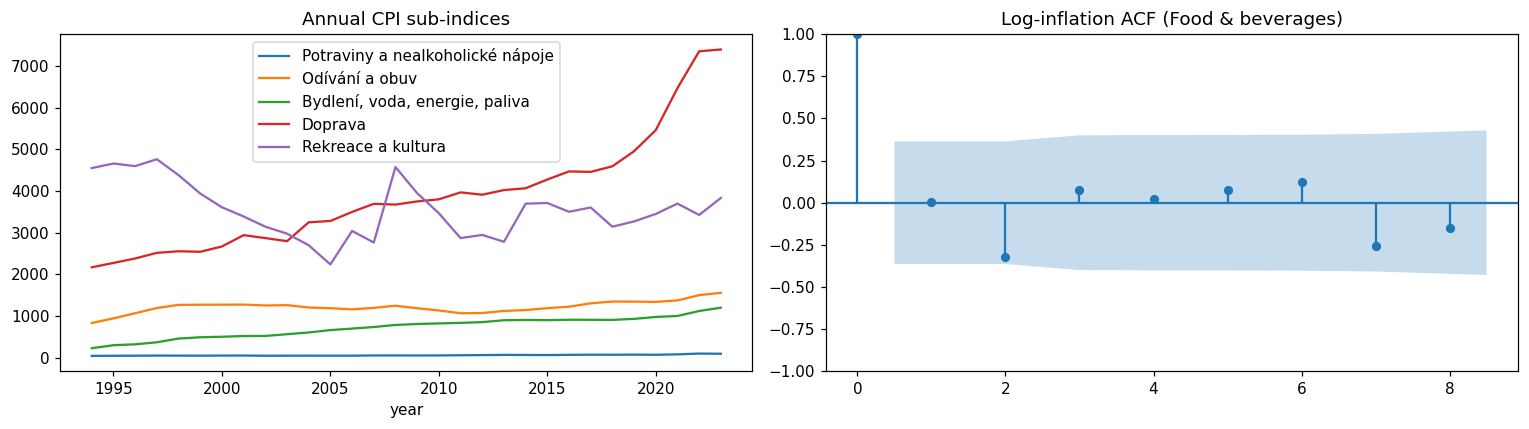

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Annual CPI sub-indices
for cat, ser in series_map.items():
    ser.plot(ax=axes[0], label=cat)
axes[0].set_title('Annual CPI sub-indices')
axes[0].legend()

# Right: Log-inflation ACF (Food & beverages)
plot_acf(np.log(series_map[CATEGORIES[0]]).diff().dropna(), lags=8, ax=axes[1])
axes[1].set_title('Log-inflation ACF (Food & beverages)')

# Save the figure
FIG_DIR.mkdir(exist_ok=True)
fig.savefig(FIG_DIR / "cpi_subindices_and_acf.png")

plt.tight_layout()
plt.show()

**Left:**  Annual CPI sub-indices (1994–2023), illustrating upward trends, slope changes (e.g., accelerated Transport inflation post-2020) and differing volatility across categories.

**Right:** Autocorrelation of year-over-year log price changes for Food & beverages, showing a strong lag-1 correlation (≈0.4–0.5) and rapid decay thereafter, which motivates AR(1) modeling of inflation shocks.

## 3 · Candidate forecasting methods
Tested models:
- **Linear-log**: exponential growth trend
- **AR(1) inflation**: shocks mean-revert in log space
- **Piece-wise trend**: allow post-2020 slope change
- **ETS(A,A,N)**: classical exponential smoothing

Next: compare predictive accuracy on 2019–2023 hold-out.

In [100]:
import numpy.linalg as npl

# 3.1 Log-linear trend
def forecast_loglinear(ser, horizon):
    yrs = ser.index; y = np.log(ser.values)
    X = np.vstack([np.ones_like(yrs), yrs]).T
    b = npl.lstsq(X, y, rcond=None)[0]
    fut = np.arange(yrs.max()+1, horizon+1)
    return pd.Series(np.exp(b[0] + b[1]*fut), index=fut)

# 3.2 AR(1) on log-inflation
def forecast_ar1(ser, horizon):
    infl = np.log(ser).diff().dropna()
    m = AutoReg(infl, lags=1, old_names=False).fit()
    steps = horizon - ser.index.max()
    preds = [infl.iloc[-1]]
    for _ in range(steps-1): preds.append(m.params.iloc[0] + m.params.iloc[1]*preds[-1])
    cum = np.log(ser.iloc[-1]) + np.cumsum(preds)
    years = np.arange(ser.index.max()+1, horizon+1)
    return pd.Series(np.exp(cum), index=years)

# 3.3 Piece-wise trend
def forecast_piecewise(ser, bp, horizon):
    yrs = ser.index.values; y = np.log(ser.values)
    post = (yrs>bp).astype(int)
    X = np.column_stack([np.ones_like(yrs), yrs, post, yrs*post])
    beta = npl.lstsq(X, y, rcond=None)[0]
    fut = np.arange(yrs.max()+1, horizon+1)
    postf = (fut>bp).astype(int)
    Xf = np.column_stack([np.ones_like(fut), fut, postf, fut*postf])
    return pd.Series(np.exp(Xf @ beta), index=fut)

# 3.4 Holt-Winters ETS
def forecast_ets(ser, horizon):
    model = ExponentialSmoothing(ser, trend='add', seasonal=None).fit()
    f = model.forecast(horizon-ser.index.max())
    f.index = np.arange(ser.index.max()+1, horizon+1)
    return f

## 4 · Comparative evaluation & selection
Compute RMSE on 2019–2023 hold-out for each model and category. Select model with lowest RMSE per series.

In [101]:
from math import sqrt

def calc_rmse(pred, obs): 
    return sqrt(((pred-obs)**2).mean())

rmse_table = pd.DataFrame()
for cat, ser in series_map.items():
    train = ser[ser.index<=2018]; test = ser[ser.index>2018]
    preds = {
        'Log': forecast_loglinear(train, 2023),
        'AR1': forecast_ar1(train, 2023),
        'Piece': forecast_piecewise(train, BREAKPOINT, 2023),
        'ETS': forecast_ets(train, 2023)
    }
    scores = {m: calc_rmse(p.loc[test.index], test) for m,p in preds.items()}
    rmse_table[cat] = pd.Series(scores)

rmse_table = rmse_table.T.sort_index()

/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: Futur

## 5 · Final forecasts & uncertainty visualization
For each category:
1. Use the minimum-RMSE model
2. Generate forecasts to 2050
3. Create a 1 000-draw bootstrap fan chart around this trend
4. Save figure and append results to `forecasts_2024_2050.csv`

/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/poryadok/projects/carl-notes/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsu

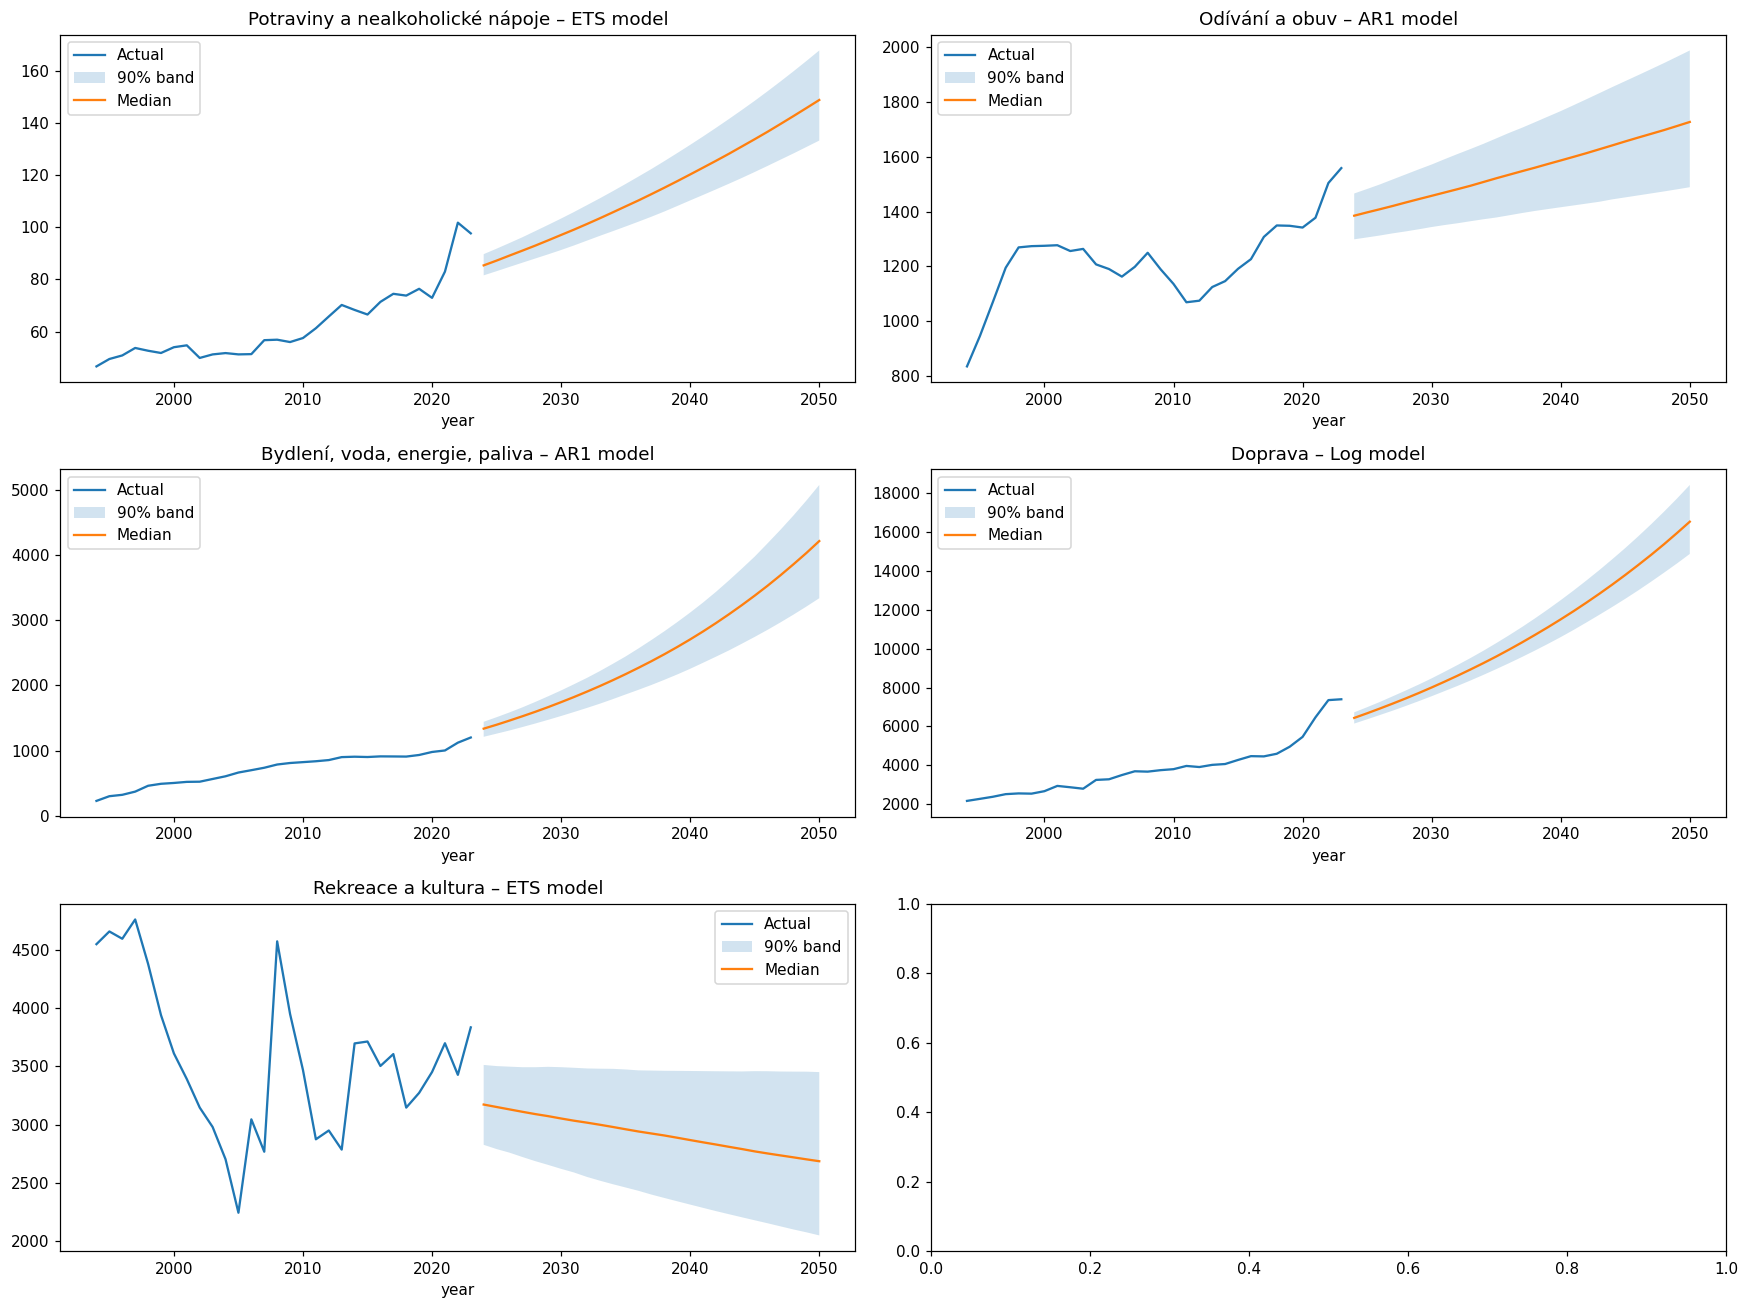

In [102]:
from numpy.random import default_rng
rng = default_rng(RNG_SEED)
FIG_DIR.mkdir(exist_ok=True)

rows = []
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (cat, ser) in enumerate(series_map.items()):
        best = rmse_table.loc[cat].idxmin()
        func = {
            'Log':forecast_loglinear,
            'AR1':forecast_ar1,
            'Piece':lambda s,h: forecast_piecewise(s,BREAKPOINT,h),
                'ETS':forecast_ets
        }[best]
        fcast = func(ser, HORIZON_YEAR)
        # bootstrap around linear trend residuals
        years = ser.index.values; logp = np.log(ser.values)
        resid = logp - np.polyval(np.polyfit(years, logp, 1), years)
        fut = fcast.index.values; n=len(fut)
        sims = np.array([np.exp(np.polyval(np.polyfit(years, logp + rng.choice(resid, len(resid), True),1), fut))
                                         for _ in range(BOOTSTRAP_DRAWS)])
        q = np.quantile(sims, [0.05,0.5,0.95], axis=0)
        # plot
        ax = axes[i]
        ser.plot(ax=ax, label='Actual',color='C0')
        ax.fill_between(fut, q[0], q[2], alpha=0.2, label='90% band')
        ax.plot(fut, q[1],color='C1',label='Median')
        ax.set_title(f"{cat} – {best} model")
        ax.legend()
        # record
        for y,val in fcast.items(): rows.append([cat, best, y, val])

plt.tight_layout()
plt.savefig(FIG_DIR/"fan_charts_all.png")
plt.show()

In [103]:
pd.DataFrame(rows, columns=['Category','Model','Year','Predicted_price'])\
  .to_csv(FORECAST_CSV, index=False)
print("Outputs saved: ", FORECAST_CSV)

Outputs saved:  forecasts_2024_2050.csv
